In [10]:
import numpy as np
import pandas as pd
import os
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
from skimage import exposure
from skimage.color import rgb2gray
import cv2
import math

In [ ]:
data_path = '/dmc/ml_storage/machine_learning/Final_ML_CBS/'
data_dir = '/dmc/ml_storage/machine_learning/Final_ML_CBS/data/'

In [ ]:
# iterate over the images in age and print if they cause an error
#data_dir = '/dmc/ml_storage/machine_learning/Final_ML_CBS/data/cohorts_5/'
data_dir = '/dmc/ml_storage/machine_learning/Final_ML_CBS/data/aug/'

for folder in os.listdir(data_dir):
    # add folder to the data_dir path
    folder_path = data_dir + folder + '/'
    for image in os.listdir(folder_path):
        try:
            img = Image.open(folder_path + image) # open the image file
            img.verify() # verify that it is, in fact an image
        except (IOError, SyntaxError) as e:
            print('Bad file:', image, folder_path) # print out the names of corrupt files


#Bad file: 000999.png
#Bad file: 006924.png
#Bad file: 008300.png

In [ ]:
def preprocessing_function(edge_enhance, rotate, equalization, blur, image):

    # apply gaussian blur to the image
    image = cv2.GaussianBlur(image, (blur, blur), 0)

    # edge enhance using PIL
    if edge_enhance:
        image = Image.fromarray(image)
        image = image.filter(ImageFilter.EDGE_ENHANCE)
        image = np.array(image)
    else:
        image = image
    # equalization
    if equalization == 'histogram':
        image = cv2.equalizeHist(image)
    elif equalization == 'adaptive':
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        image = clahe.apply(image)
    else: 
        image = image
    # rotate
    if rotate != None:
        image = cv2.rotate(image, rotate)
    else:
        image = image

    return image

In [ ]:
def crop_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # threshold 
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    hh, ww = thresh.shape

    # make bottom 2 rows black where they are white the full width of the image
    thresh[hh-3:hh, 0:ww] = 0

    # get bounds of white pixels
    white = np.where(thresh==255)
    xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])
    hd = ymax-ymin
    wd = xmax-xmin
    print(xmin,xmax,ymin,ymax)
    print(hd, wd)
    if hd > wd and (ymin <2 or ymax + 2 > img.shape[0]):
        g = 0
        j = 0
        t = (hd-wd) / 2 
        if xmin - math.floor(t) >= 0 and xmax + math.ceil(t) <= img.shape[1]:
            m = math.floor(t)
            f = math.ceil(t)
        elif xmin - math.floor(t) >= 0:
            f = img.shape[1]-xmax
            m = ((2*t)-f)
        else:
            m = xmin
            f = ((2*t)-m)
    elif hd > wd and ymin > 2 and ymax + 2 < img.shape[0]:
        g = 2
        j = 2
        t = ((hd+4)-wd) / 2
        if xmin - math.floor(t) >= 0 and xmax + math.ceil(t) <= img.shape[1]:
            m = math.floor(t)
            f = math.ceil(t)
        elif xmin - math.floor(t) >= 0:
            f = img.shape[1]-xmax
            m = ((2*t)-f)
        else:
            m = xmin
            f = ((2*t)-m)
    elif wd > hd and (xmin < 2 or xmax +2 > img.shape[1]):
        m = 0 
        f = 0
        t = (wd-hd) / 2 
        if ymin - math.floor(t) >= 0 and ymax + math.ceil(t) <= img.shape[0]:
            g = math.floor(t)
            j = math.ceil(t)
        elif ymin - math.floor(t) >= 0:
            j = img.shape[0]-ymax
            g = ((2*t)-f)
        else:
            g = ymin
            j = ((2*t)-m)
    elif wd > hd and (xmin > 2 or xmax + 2 < img.shape[1]):
        m = 2 
        f = 2
        t = ((wd+4)-hd) / 2 
        if ymin - math.floor(t) >= 0 and ymax + math.ceil(t) <= img.shape[0]:
            g = math.floor(t)
            j = math.ceil(t)
        elif ymin - math.floor(t) >= 0:
            j = img.shape[0]-ymax
            g = ((2*t)-f)
        else:
            g = ymin
            j = ((2*t)-m)
    # crop the image at the bounds adding back the two blackened rows at the bottom
    print(g,j,m,f)
    xx = int(ymin-g)
    xy = int(ymax+j)
    yx = int(xmin-m)
    yy = int(xmax+f)
    crop = img[xx:xy, yx:yy,0]
    return crop

In [ ]:
data_dir = '/home/julius/Desktop/archive/cohorts_5/'
target_path = '/home/julius/Desktop/archive/cohorts_5_aug/'

for folder in os.listdir(data_dir):
    # add folder to the data_dir path
    folder_path = data_dir + folder + '/'
    for image in os.listdir(folder_path):
        img = cv2.imread(folder_path + image, cv2.COLOR_BGR2GRAY)
        print(folder_path + image)
        # cropping 
        img = crop_image(img)
         
        for i in range(0, 3):
            if i == 0:
                rotation = None
            elif i == 1:
                rotation = cv2.ROTATE_90_CLOCKWISE
            elif i == 2:
                rotation = cv2.ROTATE_90_COUNTERCLOCKWISE
            else:
                rotation = cv2.ROTATE_180
            temp = preprocessing_function(True, rotation, 'adaptive', 1, img)
            # show the image
            path = target_path + str(i) + image
            cv2.imwrite(target_path + str(i) + image, temp)
    break

In [11]:
data_path = '/home/julius/Desktop/archive/'
train_age = pd.read_csv(data_path + 'train_age.csv')
train_gender = pd.read_csv(data_path + 'train_gender.csv')

In [12]:
train_full = train_age
train_full['age'] = train_full['age'].apply(lambda x: round(x))
train_full['gender'] = train_gender['gender'].astype(str)
train_full['age'] = train_age['age'].astype(str)
train_full['combine'] = train_full[['age', 'gender']].agg('-'.join, axis=1)
#train_full.to_csv(data_path + 'train_full.csv', index=False)
for i in range(len(train_full)):
    if train_full.gender[i] == "1":
        train_full.gender[i] = "Male"
    else:
        train_full.gender[i] = "Female"

/tmp/ipykernel_470631/3235613034.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_full.gender[i] = "Female"
/tmp/ipykernel_470631/3235613034.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_full.gender[i] = "Male"


In [8]:
train_full_cohort = train_age
train_full_cohort['age'] = train_full_cohort['age'].apply(lambda x: round(x))
# group age into cohorts of 5 years starting from 15
for i in range(15, 100, 5):
    train_full_cohort['age'] = np.where((train_full_cohort['age'] >= i) & (train_full_cohort['age'] < i + 5), i, train_full_cohort['age'])
train_full_cohort['gender'] = train_gender['gender'].astype(str)
train_full_cohort['age'] = train_full_cohort['age']
#train_full_cohort['combine'] = train_full_cohort[['age', 'gender']].agg('-'.join, axis=1)
#train_full_cohort.to_csv(data_path + 'train_full_cohort.csv', index=False)

# replace the gender with male and female
for i in range(len(train_full_cohort)):
    if train_full_cohort.gender[i] == "1":
        train_full_cohort.gender[i] = "Male"
    else:
        train_full_cohort.gender[i] = "Female"

/tmp/ipykernel_470631/3804404624.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_full_cohort.gender[i] = "Female"
/tmp/ipykernel_470631/3804404624.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_full_cohort.gender[i] = "Male"


In [ ]:
for label in train_full['combine'].unique():
    df = train_full[train_full['combine'] == label]
    ids = []
    for id in df['imageId']:
        #make sure the id is six digits long, if not fill with zeros from the left
        id = str(id).zfill(6)
        # add the .png extension
        id = id + '.png'
        ids.append(id)
        #create a csv file with the imageIds for this label
    ids = pd.DataFrame(ids)
    ids.to_csv(data_path + 'combined/' + str(label) + '.csv', index=False, header=False)

In [ ]:
for label in train_full_cohort['combine'].unique():
    df = train_full_cohort[train_full_cohort['combine'] == label]
    ids = []
    for id in df['imageId']:
        #make sure the id is six digits long, if not fill with zeros from the left
        id = str(id).zfill(6)
        # add the .png extension
        id = id + '.png'
        ids.append(id)
        #create a csv file with the imageIds for this label
    ids = pd.DataFrame(ids)
    ids.to_csv(data_path + 'cohorts_5/' + str(label) + '.csv', index=False, header=False)

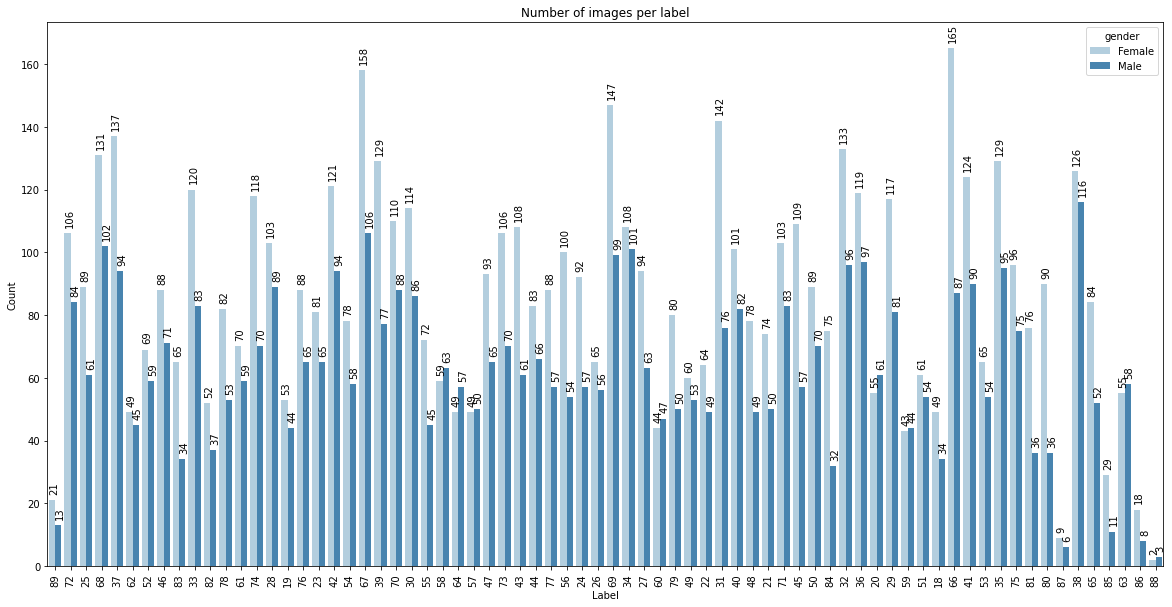

In [16]:
# plot the numer of images per label as a bar chart using seaborn sorted by label and using a blue palette
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
ax = sns.countplot(x='age', data=train_full, hue = 'gender', palette='Blues')
plt.title('Number of images per label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)

# show the number of images per label above the bars, rotated by 90 degrees and rounded to the nearest integer. center on teh top of the bar
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x(), p.get_height()+2.5), rotation=90)
plt.show()

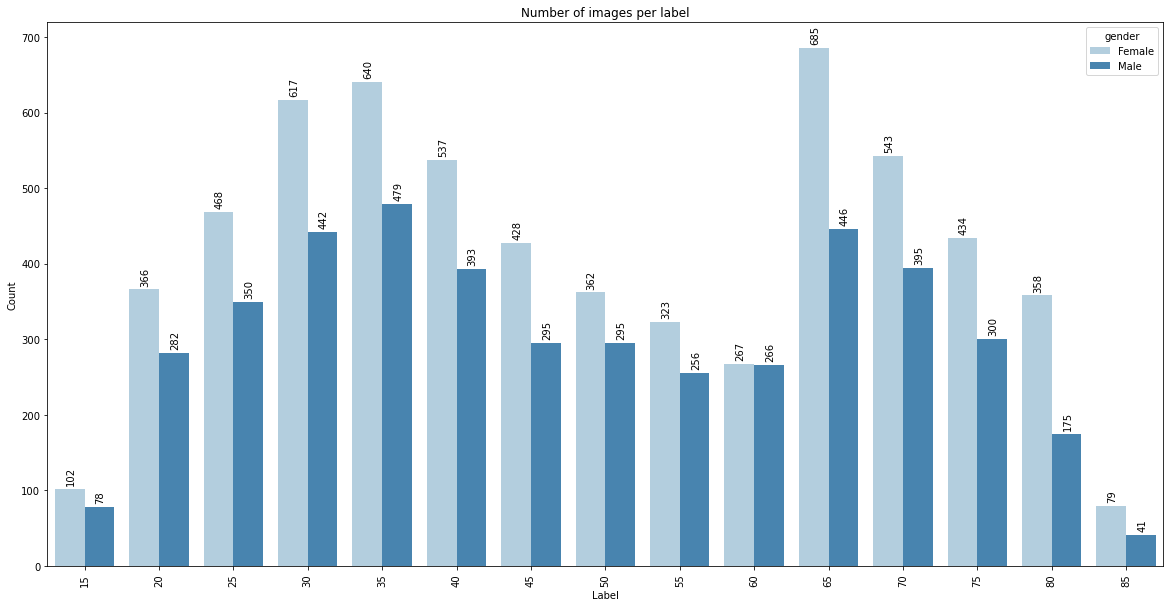

In [9]:
# plot the numer of images per label as a bar chart using seaborn sorted by label and using a blue palette
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
ax = sns.countplot(x='age', data=train_full_cohort, hue = 'gender', palette='Blues')
plt.title('Number of images per label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)

# show the number of images per label above the bars, rotated by 90 degrees and rounded to the nearest integer. center on teh top of the bar
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+7.5), rotation=90)
plt.show()


In [ ]:
# for all labels in train_age, create a csv_file containing all the imageIds for this label
for label in train_age['age'].unique():
    df = train_age[train_age['age'] == label]
    ids = []
    for id in df['imageId']:
        #make sure the id is six digits long, if not fill with zeros from the left
        id = str(id).zfill(6)
        # add the .png extension
        id = id + '.png'
        ids.append(id)
        #create a csv file with the imageIds for this label
        # round the variable label to a whole number
    label = round(label)
    ids = pd.DataFrame(ids)
    ids.to_csv(data_path + 'data/age_csvs/' + str(label) + '.csv', index=False, header=False)


In [ ]:
for label in train_gender['id'].unique():
    df = train_gender[train_gender['id'] == label]
    ids = []
    for id in df['imageId']:
        #make sure the id is six digits long, if not fill with zeros from the left
        id = str(id).zfill(6)
        # add the .png extension
        id = id + '.png'
        ids.append(id)
        #create a csv file with the imageIds for this label
        # round the variable label to a whole number
    label = round(label)
    ids = pd.DataFrame(ids)
    ids.to_csv(data_path + 'data/gender_csvs/' + str(label) + '.csv', index=False, header=False)